In [51]:

import torch
from datasets import load_dataset
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import pickle
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


dataset = load_dataset("ag_news")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Using device: cuda


Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [52]:
# --- Configuration ---
MODEL_NAME = "roberta-base"
NUM_LABELS = 4
# --- IMPORTANT: Adjust these based on parameter count ---
LORA_R = 3  # Increased rank
LORA_ALPHA = 2*LORA_R # Keep alpha = 2*r heuristic
TARGET_MODULES = ["query", "dense"]

LEARNING_RATE = 3e-4 # Lowered learning rate
EPOCHS = 10 # Increased epochs (will stop early)
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 64
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06 # Warmup over 6% of total steps
LR_SCHEDULER = "cosine" # Cosine decay scheduler
GRAD_ACCUM_STEPS = 2 # Simulate batch size 32 (16*2)
LABEL_SMOOTHING = 0.1 # Added label smoothing
EARLY_STOPPING_PATIENCE = 3 # Stop if eval accuracy doesn't improve for 3 epochs

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

# --- LoRA Configuration ---
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=TARGET_MODULES,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(model, lora_config)
model.to(device)

# --- !!! Crucial Check !!! ---
print("Parameter Count Check:")
model.print_trainable_parameters()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Count Check:
trainable params: 985,348 || all params: 125,638,664 || trainable%: 0.7843


In [53]:

training_args = TrainingArguments(
    output_dir="./results_improved",
    evaluation_strategy="epoch",
    save_strategy="epoch", # Save checkpoints each epoch to load the best later
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS, # Use gradient accumulation
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    logging_dir="./logs_improved",
    logging_strategy="steps",
    logging_steps=50, # Log more frequently
    load_best_model_at_end=True, # Load the best model based on metric
    metric_for_best_model="accuracy", # Use accuracy to determine the best model
    greater_is_better=True, # Higher accuracy is better
    report_to="none", # Change to "wandb" or "tensorboard" for better tracking
    warmup_ratio=WARMUP_RATIO, # Add warmup
    lr_scheduler_type=LR_SCHEDULER, # Use specified scheduler
    label_smoothing_factor=LABEL_SMOOTHING, # Add label smoothing
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [54]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"], # Make sure this exists
    eval_dataset=tokenized_dataset["test"],   # Make sure this exists
    tokenizer=tokenizer,   
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE)] # Add early stopping
)

trainer.train()

<ipython-input-54-80926f947849>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.499100,0.482106,0.933421
2,0.470900,0.464764,0.942763
3,0.456200,0.458979,0.944737
4,0.434600,0.459695,0.947368
5,0.432400,0.460522,0.948421
6,0.425600,0.461025,0.949079
7,0.414900,0.457466,0.950921
8,0.407000,0.458649,0.950921
9,0.396100,0.458319,0.951711
10,0.407600,0.458355,0.952237


TrainOutput(global_step=37500, training_loss=0.4468939089457194, metrics={'train_runtime': 12575.4012, 'train_samples_per_second': 95.424, 'train_steps_per_second': 2.982, 'total_flos': 7.98470774784e+16, 'train_loss': 0.4468939089457194, 'epoch': 10.0})

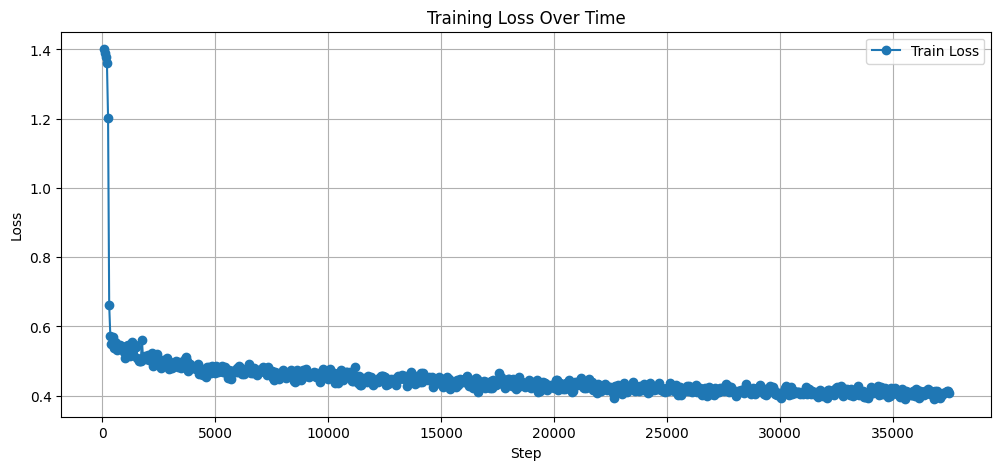

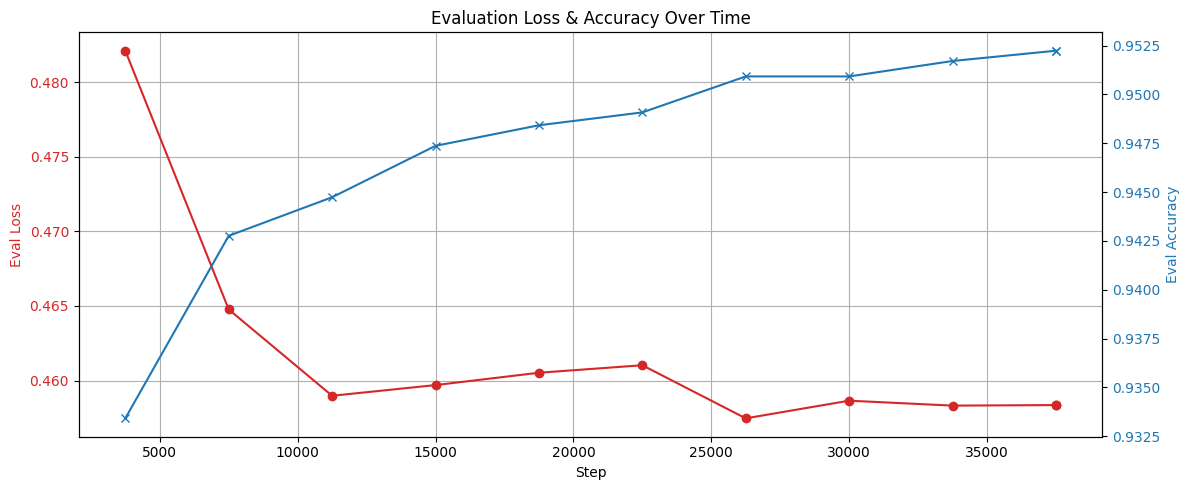

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract logged metrics
logs = trainer.state.log_history

# Convert to DataFrame
df = pd.DataFrame(logs)

# Filter for training and evaluation logs
train_loss_df = df[df["loss"].notnull()]
eval_df = df[df["eval_loss"].notnull()]

# --- Plot Training Loss ---
plt.figure(figsize=(12, 5))
plt.plot(train_loss_df["step"], train_loss_df["loss"], label="Train Loss", marker='o')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.legend()
plt.show()

# --- Plot Evaluation Loss and Accuracy ---
fig, ax1 = plt.subplots(figsize=(12, 5))

color = 'tab:red'
ax1.set_xlabel("Step")
ax1.set_ylabel("Eval Loss", color=color)
ax1.plot(eval_df["step"], eval_df["eval_loss"], label="Eval Loss", color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Second axis for accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel("Eval Accuracy", color=color)
ax2.plot(eval_df["step"], eval_df["eval_accuracy"], label="Eval Accuracy", color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Evaluation Loss & Accuracy Over Time")
fig.tight_layout()
plt.show()


In [61]:
import shutil

print("Evaluating the best model loaded...")
eval_results = trainer.evaluate()
print("Final Evaluation Accuracy:", eval_results["eval_accuracy"])

print(f"The best model checkpoint path is: {trainer.state.best_model_checkpoint}")
print(f"The best model score was: {trainer.state.best_metric}")

# You can now directly use or save this best model
# Example: Save the final adapter weights (which are the best ones)
best_model_save_path = "./my_best_lora_model"
trainer.save_model(best_model_save_path)
print(f"Best LoRA adapter saved to {best_model_save_path}")

# Now zip the model directory
shutil.make_archive(best_model_save_path, 'zip', best_model_save_path)
print(f"Zipped model saved to {best_model_save_path}.zip")

Evaluating the best model loaded...
Final Evaluation Accuracy: 0.9522368421052632
The best model checkpoint path is: ./results_improved/checkpoint-37500
The best model score was: 0.9522368421052632
Best LoRA adapter saved to ./my_best_lora_model
Zipped model saved to ./my_best_lora_model.zip


In [62]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 985348


In [63]:
from datasets import Dataset
from torch.utils.data import DataLoader

# Load dataset object
with open("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl", "rb") as f:
    test_dataset = pickle.load(f)

# Convert to HuggingFace Dataset (already is, but this helps formatting)
test_dataset = Dataset.from_dict({"text": test_dataset["text"]})

# Tokenize function
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Apply tokenizer
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Create PyTorch DataLoader for batching
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=64)

# Prediction loop
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_predictions.extend(preds.cpu().numpy())


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [64]:
df = pd.DataFrame({
    "ID": list(range(len(all_predictions))),   # ID ✅
    "Label": all_predictions
})
df.to_csv("submission.csv", index=False)
print("✅ Batched predictions complete. Saved to submission.csv.")

✅ Batched predictions complete. Saved to submission.csv.
